In [1]:
# Import necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Import seaborn library and set context and style
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Import warnings and set filter to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import time library
from time import time

# Import matplotlib ticker and scipy stats
import matplotlib.ticker as tkr
from scipy import stats

# Import statistical tools for time series analysis
from statsmodels.tsa.stattools import adfuller

# Import preprocessing from sklearn
from sklearn import preprocessing

# Import partial autocorrelation function from statsmodels
from statsmodels.tsa.stattools import pacf

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import math library
import math

# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Import mean squared error and mean absolute error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import early stopping from keras callbacks
from keras.callbacks import EarlyStopping

2023-04-10 19:18:17.175162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('household_power_consumption.txt', delimiter=';')
data.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
# by combining the two columns and converting to datetime format
data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])


In [5]:
# Convert the 'Global_active_power' column to numeric format
# and remove any rows with NaN values
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data = data.dropna(subset=['Global_active_power'])

In [6]:
# Convert the 'date_time' column to datetime format
data['date_time'] = pd.to_datetime(data['date_time']) 

In [28]:
#Transform the Global_active_power column of the data DataFrame into a numpy array of float values

dataset = data.Global_active_power.values.astype('float32')
#Reshape the numpy array into a 2D array with 1 column

dataset = np.reshape(dataset, (-1, 1))
#Create an instance of the MinMaxScaler class to scale the values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
#Fit the MinMaxScaler to the transformed data and transform the values

dataset = scaler.fit_transform(dataset)
#Split the transformed data into a training set (80%) and a test set (20%)

train_val_size = int(len(dataset) * 0.90)
train_size = int(train_val_size*0.80) 
test_size = len(dataset) - train_size
train, test, val = dataset[0:train_size,:], dataset[train_val_size:,:], dataset[train_size:train_val_size,:]

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [29]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_val, Y_val = create_dataset(val, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [31]:
X_train.shape, X_val.shape, X_test.shape

((1475450, 30), (368840, 30), (204897, 30))

In [32]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))


# LSTM Model

In [11]:
class MonteCarloLSTM(keras.layers.LSTM):
  def call(self, inputs):
    return super().call(inputs, training=True)

In [33]:
import tensorflow.keras.backend as K
K.clear_session()
# Defining the LSTM model
model = Sequential()

# Adding the first layer with 100 LSTM units and input shape of the data
model.add(MonteCarloLSTM(100,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.4))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.2))
model.add(Dense(32, activation= 'relu'))
# Adding a dense layer with 1 unit to make predictions
model.add(Dense(1))

# Displaying a summary of the model
model.summary()

# Compiling the model with mean squared error as the loss function and using Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_val, Y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 monte_carlo_lstm (MonteCarl  (None, 100)              52400     
 oLSTM)                                                          
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55,665
Trainable params: 55,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1190/1190 [==============================] - 9s 6ms/step - loss: 0.0011 - val_loss: 4.9761e-04
Epoch 2/20
1

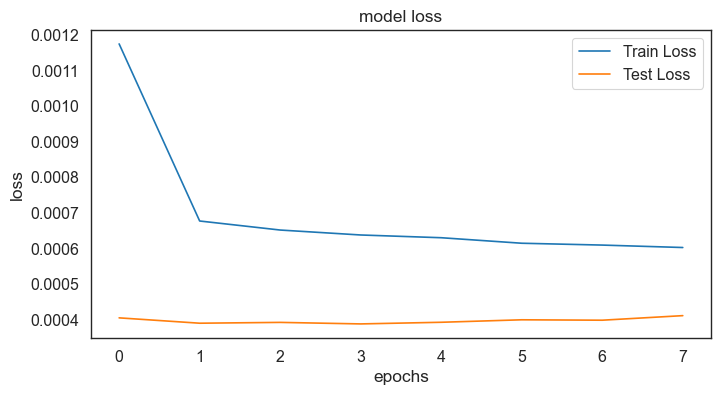

In [13]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [20]:
Y_test = scaler.inverse_transform([Y_test])


In [21]:
X_MC_test = X_test[-200:,:,:]
X_MC_test.shape

(200, 1, 30)

In [16]:
#A function to do prediction sevral times over a set X, using dropout during prediction
def predict_proba(X, model, num_prediction):
    preds = [model(X, training=True) for _ in range(num_prediction)]
    preds_ar = np.reshape(preds, (num_prediction, X.shape[0]))
    preds_ar = scaler.inverse_transform(preds_ar)
    std = [preds_ar[:,i].std() for i in range(X.shape[0])]
    mean = [preds_ar[:,i].mean() for i in range(X.shape[0])]
    return mean, std
     

In [24]:
#To plot the prediction and uncertainty for whole X_test
def plot_uncertainty(y,std):
   plt.figure(figsize=(20, 6), dpi=200)
   x = [x for x in range(len(y))]
   plt.plot(x, Y_test[0][-len(y):], 'r--', zorder=2, label="True")
   plt.plot(x, y,marker='.', label= 'Predict')
   #for k in np.linspace(1, 4, 4):
   plt.fill_between(
            x, (np.array(y) -  np.array(std)), (np.array(y) +  np.array(std)),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc.")
   plt.legend(loc="upper left")
   plt.show()

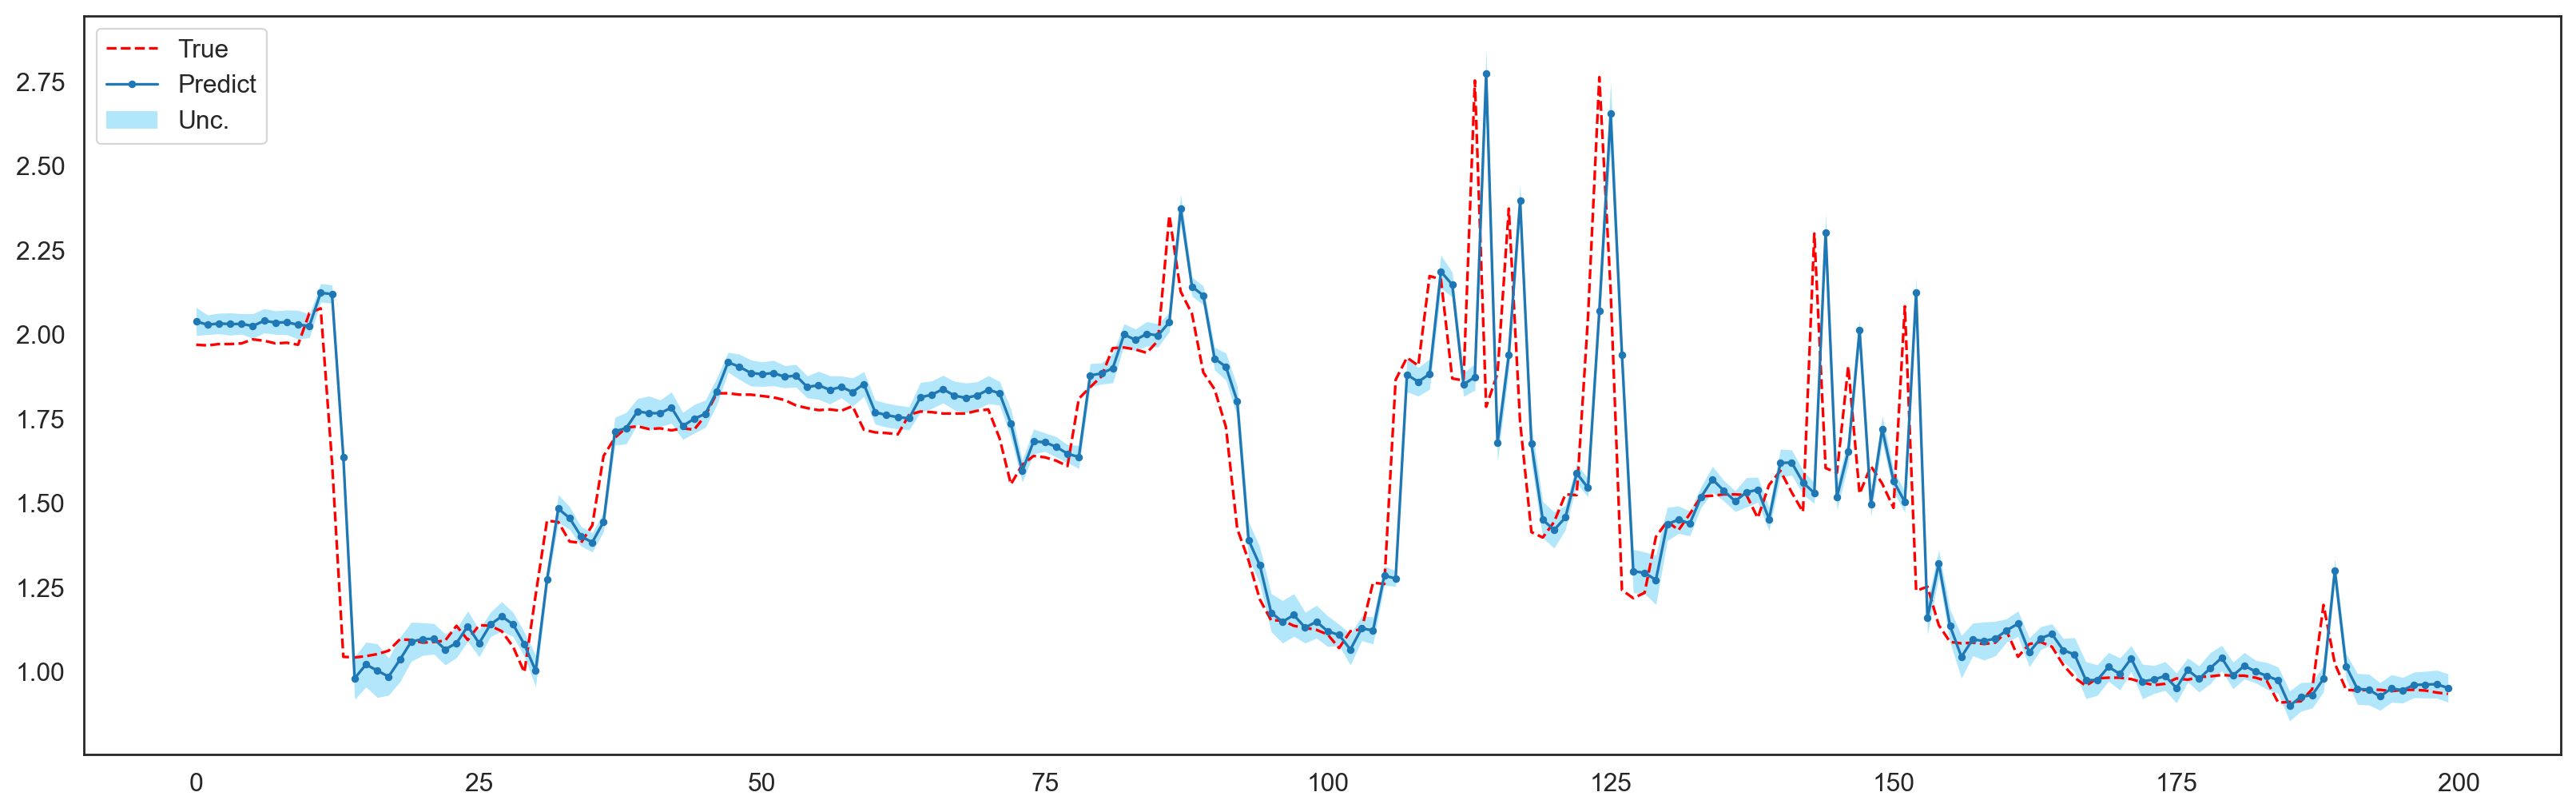

In [25]:
y1, v1 = predict_proba(X_MC_test, model, 50)
plot_uncertainty(y1,v1)